In [158]:
import math
from mxnet import nd, gluon, autograd

import mxnet as mx
import seaborn
import matplotlib.pyplot as plt

In [180]:
ctx = mx.gpu()
batch_size=10
sample_size = 10000

# Crearting Synthetic Data

In [181]:
X = nd.random_normal(loc=0, scale=1, shape=(sample_size,2))
def fn(X, noise=.001):
    noise_term = noise * nd.random_normal(loc=0, scale=1, shape=(sample_size,))
    return (2 * X[:, 0] + 3.1 * X[:, 1] + math.pi) + noise
y = fn(X)
print(X.shape, y.shape)

(10000, 2) (10000,)


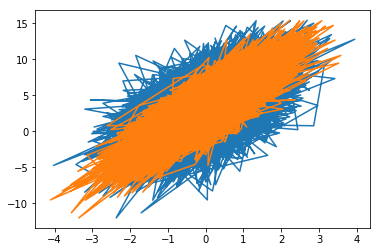

In [182]:
plt.plot(X.asnumpy(),y.asnumpy())

plt.show()

In [183]:
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y), shuffle=True, batch_size=batch_size, last_batch='keep')

# Define a Network

In [184]:
def define_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    return net

net = define_net()
net.collect_params()



# Initialzie Parameters

In [186]:
net.collect_params().initialize(mx.init.Normal(), ctx=ctx, force_reinit=True)

## More initialization algorithms and parameters
for further information check the [API documentation](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html)

|Function|Description|notes|
|:---|:---|:---|
|Uniform|Initializes weights with random values uniformly sampled from a given range.|![dd](http://mathworld.wolfram.com/images/eps-gif/UniformDistribution_651.gif)A uniform distribution has constant probability|
|Normal|Initializes weights with random values sampled from a normal distribution with a mean of zero and standard deviation of sigma.|![](http://mathworld.wolfram.com/images/eps-gif/NormalDistribution_651.gif)A normal distribution in a variate X with mean mu and variance sigma^2 is a statistic distribution with probability density function P(x)|
|Load|Initializes variables by loading data from file or dict.||
|Mixed|Initialize parameters using multiple initializers.||
|Zero|Initializes weights to zero.||
|One|Initializes weights to one.||
|Constant|Initializes the weights to a given value.||
|Orthogonal|Initialize weight as orthogonal matrix.|A Matrix A is orthagonal if $AA^T=I\ or\ A^{-1}=A^T$. Intentions is to use initialize conditions to benefit from depth independent finite delay in learning|
|Xavier|Returns an initializer performing “Xavier” initialization for weights.|This initializer is designed to keep the scale of gradients roughly the same in all layers. Randomizarion can be Uniform or Average|
|MSRAPrelu|Initialize the weight according to a MSRA paper.|[paper](https://arxiv.org/pdf/1502.01852.pdf)|
|Bilinear|Initialize weight for upsampling layers.|
|FusedRNN|Initialize parameters for fused rnn layers.|![](../images/FusedRNN.png)[1]|
|LSTMBias|Initialize all biases of an LSTMCell to 0.0 except for the forget gate whose bias is set to custom value.|

In [187]:
net.collect_params()

sequential12_ (
  Parameter sequential12_dense0_weight (shape=(1, 0), dtype=float32)
  Parameter sequential12_dense0_bias (shape=(1,), dtype=float32)
)

In [188]:
some_data = nd.array([[1,2]], ctx=ctx)
print(some_data.shape, net(some_data))

(1, 2) 
[[-0.02159411]]
<NDArray 1x1 @gpu(0)>


In [189]:
loss_fn = gluon.loss.L2Loss()

# Optimization
Gluon Trainer applies and optimizer and set parameters for that optimizer.

In [190]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': .9})

ref: [2][3][4][5]

# Further optimization algorithms
Gradient Descent's goal is to minimize the objective fucnction $J(\theta)$ parameterized by a model's prameters $\theta$ through updating the parameters in the opposite direction of the gradient of the objective function. learning rate $\eta$ determines the stize of the step we are taking in the direction of a local minima.



|Function|Description|notes|
|:---|:---|:---|
|SGD|Stochastic Gradient Descent with momentum and weight decay|Applies SGD to each minibatch. A good rule of thump for setting the parameters is learning rate of .001 with momentum of .9. SGD has trouble navigating areas that one one dimention is significantly more steep than others. SGD can get stuck in local minimas. adding a momentum term (fraction $\lambda$ to previous update term) we can address this problem to some extent|![](http://ruder.io/content/images/2015/12/without_momentum.gif)|
|NAG|Nesterov Accelerated Gradient|Momentum does continue down the slope with speed. Knowing where the gradient is headed helps slowing down the descent towards the local minimas. NAG looks ahead to approximate the future position of parameters and adaptively adjust the momentum. NAG first makes a big jump in the direction of the previous accumulated gradient (brown vector), measures the gradient and then makes a correction (red vector), which results in the complete NAG update (green vector). NAG can help with RNN training performance.|![](http://ruder.io/content/images/2016/09/nesterov_update_vector.png)|
|RMSProp|RMSProp Optimizer|RMSProp is similar to AdaDelta and saves the same functino of reducing agressiveness of AdaGrad decaying of learning rate.||
|adam|Adaptive Moment Estimation|Adam is another adaptive variant of SGD. Adam can be viewed as a combination of RMSprop and momentum. It works better than other adaptive methods in most cases||
|AdaGrad|Adaptive Gradinet Descent|Adaptively reducing learning rate to the parameters to perform smaller updates. This results in large updates in the beginning and progressively smaller updates, resulting in faster convergence.||
|AdaDelta|An extension of AdaGrad that reduces agressiveness of AdaGrad|Ada Delta tends to use a decaying average of all the past gradients||
|Adamax|Generalized case of adam|The vt factor in the Adam update rule scales the gradient inversely proportionally to the $\mathcal{l}_2$ norm of the past gradients and current gradient. Adamax generalizes this to $\mathcal{l}_{\infty}$||
|Nadam|Nesterov-accelerated Adaptive Moment Estimation|Nadam combines Nadam and NAG. It improves Adam by using smarter momentum term as oppsoed to vanilla momentum.||
|DCASGD [3]|Delay Compensated Asynchronous Stochastic Gradient Descent|ASGD is designed to asynchronously update the gradients, but sufferes from "delayed gradients". This is when a worker updates the global model, but the model has already been updated by another worker. DCASGD compensates this delay. This is a useful method for very large and deep models.|![](../images/CIFAR10DCASGD.png)![](../images/ImageNetDCASGD.png)|
|SGLD|Stochastic Gradient Langevin Dynamics|[paper](https://arxiv.org/abs/1702.05575)|
|Signum[4]|Compressed Optimisation for Non-Convex Problems|Cost of communicating gradients could be a major bottleneck in distributing learning actoss multiple workers. signSGD alleviates this problem by transmitting just the sign of each minibatch stochastic gradient.|![](../images/Signum.png) SGD---Signum---Adam|
|FTML[5]|Follow the Moving Leader|Inspired by onlne learning algorithms based on Follow the Regularized Leader provides improved stability over RMSProp and better performance over adam, especially in changing environments|![](../images/FTML.png)  Results on neural conversational model|
|LBSGD [6][7]|Large Batch SGD with momentum and weight decay|Large batches help increasing training speed, but come at teh cost of loss of stability. There are techniques that allow us to train models on large batches (1000 scale) while performing as well as training the same model on small batch size. The techniques hinge on the idea of adaptive batch size and include warmupss, Linear Scaling, and Batch Normalization|![](https://cdn-images-1.medium.com/max/2000/1*iUXQPXWTHbfPlKIzNq75mQ.png)|
|Ftrl|[Ftrl optimizer](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.Ftrl)|[paper](http://dl.acm.org/citation.cfm?id=2488200)|


|||
|---|---|
|![](http://ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif)|![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)|
|SGD optimization on loss surface contours|SGD optimization on saddle point|REF:[2]|




for further information please check [MXNet documentation](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html).

In [1]:
epochs = 2
for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            y_hat = net(data)
            loss = loss_fn(y_hat, label)
        autograd.backward(loss)
        trainer.step(batch_size=batch_size)
    
    print("epoch: {}".format(e))

NameError: name 'train_data' is not defined

In [197]:
epochs = 10
log_interval = 100
metrics = mx.metric.RMSE()
log = []
for e in range(epochs):
    metrics.reset()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            y_hat = net(data)
            loss = loss_fn(y_hat, label)
        autograd.backward(loss)
        trainer.step(batch_size=batch_size)
        metrics.update(labels=loss, preds=y_hat)
        log.append(metrics.get()[1])
        if not(i % log_interval):
            print("epoch: {}; batch: {}; RMSE: {}".format(e,i,metrics.get()[1]))

epoch: 0; batch: 0; RMSE: 4.734167098999023
epoch: 0; batch: 100; RMSE: 4.790047444919549
epoch: 0; batch: 200; RMSE: 4.833220873306047
epoch: 0; batch: 300; RMSE: 4.786147836038837
epoch: 0; batch: 400; RMSE: 4.812712255558766
epoch: 0; batch: 500; RMSE: 4.817925774408672
epoch: 0; batch: 600; RMSE: 4.79062292302111
epoch: 0; batch: 700; RMSE: 4.774391375662767
epoch: 0; batch: 800; RMSE: 4.780839579531018
epoch: 0; batch: 900; RMSE: 4.775702058408951
epoch: 1; batch: 0; RMSE: 4.83244514465332
epoch: 1; batch: 100; RMSE: 4.791149342414176
epoch: 1; batch: 200; RMSE: 4.772000542920621
epoch: 1; batch: 300; RMSE: 4.754435997072644
epoch: 1; batch: 400; RMSE: 4.773566507639136
epoch: 1; batch: 500; RMSE: 4.730222532611169
epoch: 1; batch: 600; RMSE: 4.741884391042039
epoch: 1; batch: 700; RMSE: 4.739858454882503
epoch: 1; batch: 800; RMSE: 4.75100929341215
epoch: 1; batch: 900; RMSE: 4.7575993163471875
epoch: 2; batch: 0; RMSE: 3.4045352935791016
epoch: 2; batch: 100; RMSE: 4.79150846689

# Refrences:
1. EcoRNN: Fused LSTM RNN Implementation with Data Layout Optimization Zheng et al.: arXiv:1805.08899
2. Sebastian Ruder: [http://ruder.io/optimizing-gradient-descent/](http://ruder.io/optimizing-gradient-descent/)
3. Asynchronous Stochastic Gradient Descent with Delay Compensation; Zheng et al.: arXiv:1609.08326 [cs.LG]
4. Compressed Optimisation for Non-Convex Problems. Anandkumar et al.: arXiv:1802.04434 [cs.LG]
5. Follow the Moving Leader in Deep Learning. Zheng et al.: [paper](http://proceedings.mlr.press/v70/zheng17a/zheng17a.pdf)
6. Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour, He et al.: arXiv:1706.02677 [cs.CV] 
7. [Twards Data Science Blog](https://towardsdatascience.com/deep-learning-at-scale-accurate-large-mini-batch-sgd-8207d54bfe02). This is an intuitive version of [6].